# Finding the right distribution for our data
In this notebook, we’ll use the variance of the data to help us visualize it and figure out which distribution fits it best.

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import beta, norm as mvn

### Data loading
Loading the needed data to calculate the variance.

In [2]:
data_root = './data/'

In [3]:
# Reading the data
df_co2 = pd.read_csv(f'{data_root}co2_emmisions_complicated.csv')
df_co2_sectors = pd.read_csv(f'{data_root}co2_emmisions_by_sector.csv')

In [4]:
# Filtering the data only for european countries
df_co2_europe = df_co2[df_co2['Region'].str.contains('Europe', case=False, na=False)]

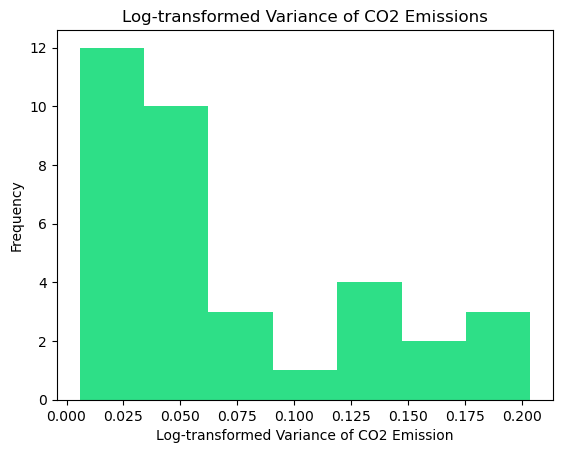

In [8]:
# Filtering the data just in case there is a different gas than CO2 in the dataset
year_cols = [col for col in df_co2_europe.columns if col.isdigit()]
df_co2_years = df_co2_europe[df_co2_europe['Substance'] == 'CO2'][['Name'] + year_cols].copy()

df_co2_years[year_cols] = df_co2_years[year_cols].apply(pd.to_numeric, errors='coerce')

# Dropping the rows with NaN values in the years column, if there are any
df_co2_years.dropna(subset=year_cols, how='all', inplace=True)

# Transforing the CO2 emissions to log-form to reduce impact of large outliers
df_co2_years_log = df_co2_years.copy()
df_co2_years_log[year_cols] = np.log(df_co2_years[year_cols])

# Calculating the variance for each country
df_co2_years_log['variance'] = df_co2_years_log[year_cols].var(axis=1, ddof=0)

df_co2_variance_log = df_co2_years_log[df_co2_years_log['variance'] > 0].copy()

plt.hist(df_co2_variance_log['variance'], bins='auto', color='#2edf87')
plt.xlabel("Log-transformed Variance of CO2 Emission")
plt.ylabel("Frequency")
plt.title("Log-transformed Variance of CO2 Emissions")
plt.show()

The histogram shows that the **Beta distribution** fits the data the best overall.

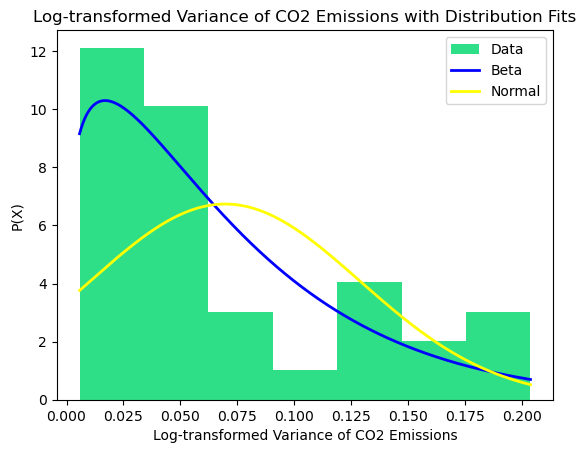

Beta distribution parameters: a = 1.2763687434379731, b = 17.04083779921736
Normal distribution parameters: mean = 0.06964965749282362, std = 0.05920980219339006


In [9]:
# Needed caluclations for the distributions
n = len(df_co2_variance_log)
mu = df_co2_variance_log['variance'].mean()
sigma2 = (n - 1) / n * df_co2_variance_log['variance'].var(ddof=1)  

data = df_co2_variance_log['variance'].values

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    pars_beta = beta.fit(data, floc=0, fscale=1) 
pars_normal = mvn.fit(data)

xr = np.linspace(min(data), max(data), 1000)

P_beta = np.array([beta.pdf(x, *pars_beta) for x in xr])
P_normal = np.array([mvn.pdf(x, *pars_normal) for x in xr])

# Plotting the Normal and Beta ditribution
counts, bins, _ = plt.hist(data, density=True, bins='auto', label="Data", color='#2edf87')
plt.plot(xr, P_beta, "-", label="Beta", linewidth=2.0, color='blue')
plt.plot(xr, P_normal, "-", label="Normal", linewidth=2.0, color='yellow')

plt.xlabel("Log-transformed Variance of CO2 Emissions")
plt.ylabel("P(X)")
plt.legend(loc='upper right')
plt.title("Log-transformed Variance of CO2 Emissions with Distribution Fits")
plt.show()

# Printing the distribution parameters
print(f'Beta distribution parameters: a = {pars_beta[0]}, b = {pars_beta[1]}')
print(f'Normal distribution parameters: mean = {pars_normal[0]}, std = {pars_normal[1]}')

These bullet points explain how we calculate the variance of CO2 emissions over time for each country in the dataset, using log-transformed values to ensure a more stable and meaningful analysis.
* We filter the dataset to keep only CO2 emission values for each country over the years.
* For each country, we take the CO2 emission values across all available years.
* These values are log-transformed to reduce the impact of very large numbers and make the data more normally distributed.
* We then calculate the variance of these log-transformed values for each country — this tells us how much a country's emissions fluctuated over time.
* Finally, countries with zero variance (no change over time) are removed so that we only analyze countries with some variability.
* Lastly, we visualize the results using Matplotlib, and the plotted curves show that the Beta distribution fits the data best.